In [221]:
import yfinance as yf
import pandas as pd
#import garch
import datetime
import warnings
import investpy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import arch
from arch import arch_model
warnings.simplefilter('ignore')    

# 1. Data importing

In [2]:
##Gold, Equity ETF, and Bitcoin data importing for full 2020##
gold_2020_df = investpy.get_etf_historical_data(etf='Perth Mint Physical Gold', country='United States', from_date='01/01/2020', to_date='31/12/2020')
dfx2 = investpy.get_etf_historical_data(etf='Vanguard FTSE Developed Markets', country='United States', from_date='01/01/2020', to_date='31/12/2020')
dfx3 = investpy.get_crypto_historical_data(crypto='bitcoin', from_date='01/01/2020', to_date='31/12/2020')

##Gold, equity and bitcoin prices for Apr-Dec 2020##
gold_df = investpy.get_etf_historical_data(etf='Perth Mint Physical Gold', country='United States', from_date='01/04/2020', to_date='31/12/2020')
gold_df['Date1'] = gold_df.index
equity_df = investpy.get_etf_historical_data(etf='Vanguard FTSE Developed Markets', country='United States', from_date='01/04/2020', to_date='31/12/2020')
equity_df['Date1'] = equity_df.index
bitcoin_df = investpy.get_crypto_historical_data(crypto='bitcoin', from_date='01/04/2020', to_date='31/12/2020')
bitcoin_df['Date1'] = bitcoin_df.index

# 2. Data processing

In [3]:
##Gold, equity and bitcoin returns calculation##
gold_df['return'] = gold_df['Close'].pct_change(periods=1)
equity_df['return'] = equity_df['Close'].pct_change(periods=1)
bitcoin_df['return'] = bitcoin_df['Close'].pct_change(periods=1)

# 3. Data summaries

In [9]:
# return the kurtosis
# skip the missing values
kurt_gold = gold_df['return'].kurtosis(skipna = True)
kurt_equity = equity_df['return'].kurtosis(skipna = True)
kurt_bitcoin = bitcoin_df['return'].kurtosis(skipna = True)
print(kurt_gold, kurt_equity, kurt_bitcoin)

4.729732844442619 2.9485276225437156 2.796264906407601


#### 3.3 calculating number of extreme values outside the (mean +- 3-sigma) range to select 2 series

In [12]:
std_gold = gold_df['return'].std(skipna = True)
std_equity = equity_df['return'].std(skipna = True)
std_bitcoin = bitcoin_df['return'].std(skipna = True)
mean_gold = gold_df['return'].mean(skipna = True)
mean_equity = equity_df['return'].mean(skipna = True)
mean_bitcoin = bitcoin_df['return'].mean(skipna = True)

In [16]:
number_gold = 0
for it in gold_df['return']:
        if (it < (mean_gold-3*std_gold)):
            number_gold += 1
        elif (it > (mean_gold+3*std_gold)):
            number_gold += 1

number_equity = 0
for it in equity_df['return']:
        if (it < (mean_equity-3*std_equity)):
            number_equity += 1
        elif (it > (mean_equity+3*std_equity)):
            number_equity += 1
            
number_bitcoin = 0
for it in bitcoin_df['return']:
        if (it < (mean_bitcoin-3*std_bitcoin)):
            number_bitcoin += 1
        elif (it > (mean_bitcoin+3*std_bitcoin)):
            number_bitcoin += 1
print(number_gold, number_equity, number_bitcoin)

3 3 6


##### Given the result, we are choosing gold and bitcoin series for further analysis

# 4. Data comparison. Copulas

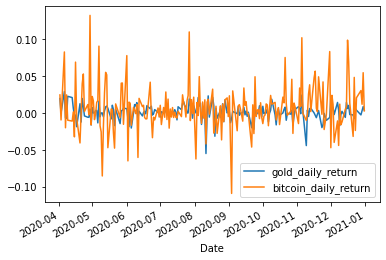

In [33]:
#plotting returns of bitcoin and gold for Apr-Dec
combined_returns_df = pd.DataFrame()
combined_returns_df['gold_daily_return'] = gold_df['return']
combined_returns_df['bitcoin_daily_return'] = bitcoin_df['return']
combined_returns_df.plot()
combined_returns_df = combined_returns_df.iloc[1:]

In [47]:
import copula
import ambhas
from copulalib.copulalib import Copula
## Using the Gumbel

In [50]:
def generateCopulas():
    #global x,y
    fig = plt.figure()
    gumbel = Copula(combined_returns_df['gold_daily_return'],combined_returns_df['bitcoin_daily_return'],family='gumbel')
    ug,vg = gumbel.generate_uv(200)
    #fig.add_subplot(2,2,3)
    plt.scatter(ug,vg,marker='.',color='green')
    #plt.ylim(0,1)
    #plt.xlim(0,1)
    plt.title('Gumbel copula')
    plt.show()
############################################
def plotData():
    #global x,y
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.hist(combined_returns_df['gold_daily_return'],bins=20,color='green',alpha=0.8,align='mid')
    plt.title('Gold ETF distribution')
    fig.add_subplot(2,2,3)
    plt.scatter(combined_returns_df['gold_daily_return'],combined_returns_df['bitcoin_daily_return'],marker="o",alpha=0.8)
    fig.add_subplot(2,2,4)
    plt.title('Joint Gold and Bitcoin')
    plt.hist(combined_returns_df['bitcoin_daily_return'],bins=20,orientation='horizontal',color='red',alpha=0.8,align='mid')
    plt.title('Bitcion ETF distribution')    
    plt.show()


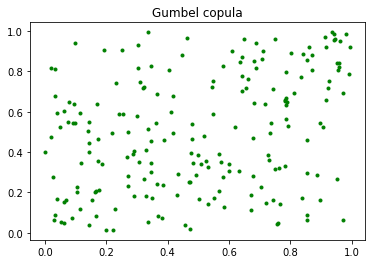

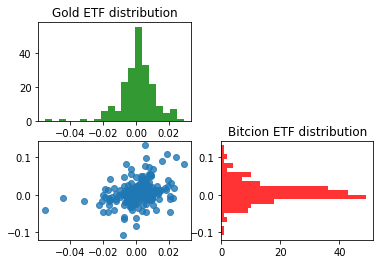

In [51]:
generateCopulas()
plotData()

## 5. Category 1 Models: Just use 1 variable.  Note that Q represents QUARTER, not question.

In [92]:
import matplotlib.pyplot as plt
import datetime 
from datetime import date
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [79]:
## seperating the quarterly data 
q2_start_date = datetime.date(2020, 4, 1)
q3_start_date = datetime.date(2020, 7, 1)
q4_start_date = datetime.date(2020, 10, 1)
q4_end_date = datetime.date(2020, 12, 31)

gold_df['Date2'] = pd.to_datetime(gold_df['Date1']).dt.date
gold_df_Q2 = gold_df.loc[(gold_df['Date2'] >= q2_start_date) & (gold_df['Date2'] < q3_start_date)]
close_Q2 = gold_df_Q2['Close'].dropna()
gold_df_Q3 = gold_df.loc[(gold_df['Date2'] >= q3_start_date) & (gold_df['Date2'] < q4_start_date)]
close_Q3 = gold_df_Q3['Close'].dropna()
gold_df_Q4 = gold_df.loc[(gold_df['Date2'] >= q4_start_date) & (gold_df['Date2'] <= q4_end_date)]
close_Q4 = gold_df_Q4['Close'].dropna()

#### ARMA model for Q2 and Q3 data

In [85]:
close_set1 = gold_df.loc[(gold_df['Date2'] >= q2_start_date) & (gold_df['Date2'] < q4_start_date)]
close = close_set1['Close'].dropna()

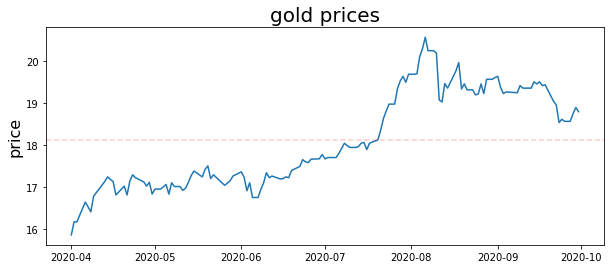

In [86]:
plt.figure(figsize=(10,4))
plt.plot(close)
plt.title('gold prices', fontsize=20)
plt.ylabel('price', fontsize=16)
#for year in range(start_date.year,end_date.year):
 #   plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(close.mean(), color='r', alpha=0.2, linestyle='--')

In [146]:
train_data = close[:q3_start_date-timedelta(days=1)]
test_data = close[q3_start_date:q4_start_date-timedelta(days=1)]

                               SARIMAX Results                                
Dep. Variable:                    Act   No. Observations:                   68
Model:                 ARIMA(2, 2, 2)   Log Likelihood                  22.118
Date:                Fri, 22 Oct 2021   AIC                            -34.235
Time:                        23:18:17   BIC                            -23.287
Sample:                             0   HQIC                           -29.909
                                 - 68                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1076      0.148     -7.469      0.000      -1.398      -0.817
ar.L2         -0.2016      0.133     -1.511      0.131      -0.463       0.060
ma.L1         -0.0021    546.963  -3.76e-06      1.0

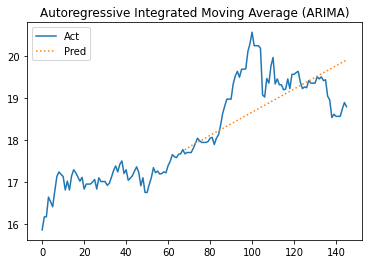

In [246]:
from statsmodels.tsa.arima.model import ARIMA
from random import random

def ARIMA_model(train,test):
    # fit model
    model = ARIMA(train['Act'], order=(2, 2, 2))
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + len(test) - 1, typ='levels')
    res=pd.DataFrame({"Pred":yhat, "Act":test["Act"].values})
    print(model_fit.summary())
    return res
 
df_train = pd.DataFrame({'email':train_data.index, 'Act':train_data.values})
df_train = df_train.drop(columns = ['email'])
#df_train['Act2'] = np.sin(np.linspace(0, 2*np.pi, 68))*50
#df_train = np.asarray(df_train)
df_test = pd.DataFrame({'email':test_data.index, 'Act':test_data.values})
df_test = df_test.drop(columns = ['email'])
#df_test['Act2'] = np.sin(np.linspace(0, 2*np.pi, 78))*50
#df_test = np.asarray(df_test)
df_ret = ARIMA_model(df_train, df_test)
show_graph(df_train, df_ret, "Autoregressive Integrated Moving Average (ARIMA)")

#### GARCH model for Q2 and Q3 data

In [158]:
train_garch = gold_df_Q2['return'].dropna()
test_garch = gold_df_Q3['return'].dropna()

Iteration:      1,   Func. Count:     32,   Neg. LLF: -213.00575022701113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -213.00575033918756
            Iterations: 5
            Function evaluations: 32
            Gradient evaluations: 1


c:\users\kunal\appdata\local\programs\python\python39\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\users\kunal\appdata\local\programs\python\python39\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


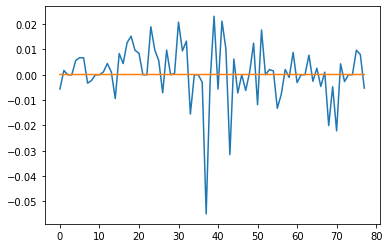

In [174]:

from matplotlib import pyplot
from arch import arch_model
model = arch_model(train_garch, mean='Zero', vol='GARCH', p=15, q=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=len(test_garch))
tes_garch = pd.DataFrame({'date':test_garch.index, 'values':test_garch.values})
pyplot.plot(tes_garch['values'])
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()

## 6. Category 2 Models: Just use 2 variables: the one you are trading, and an additional (called exogeneous variable) to enhance prediction


#### VARMA model 

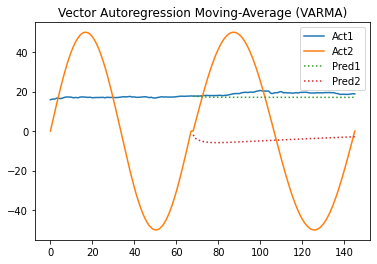

In [222]:
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

def VARMA_model(train,test):
    # fit model
    model = VARMAX(train, order=(1, 2))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.forecast(steps=len(test))
    res=pd.DataFrame({"Pred1":yhat['Act1'], "Pred2":yhat['Act2'], 
                      "Act1":test["Act1"].values, "Act2":test["Act2"].values})
    return res


def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()
df_train = pd.DataFrame({'email':train_data.index, 'Act1':train_data.values})
df_train = df_train.drop(columns = ['email'])
df_train['Act2'] = np.sin(np.linspace(0, 2*np.pi, 68))*50
#df_train = np.asarray(df_train)
df_test = pd.DataFrame({'email':test_data.index, 'Act1':test_data.values})
df_test = df_test.drop(columns = ['email'])
df_test['Act2'] = np.sin(np.linspace(0, 2*np.pi, 78))*50
#df_test = np.asarray(df_test)

df_ret = VARMA_model(df_train, df_test)
show_graph(df_train, df_ret, "Vector Autoregression Moving-Average (VARMA)")